# The Enron Scandal - A Fraud Detection Project Using Text Data

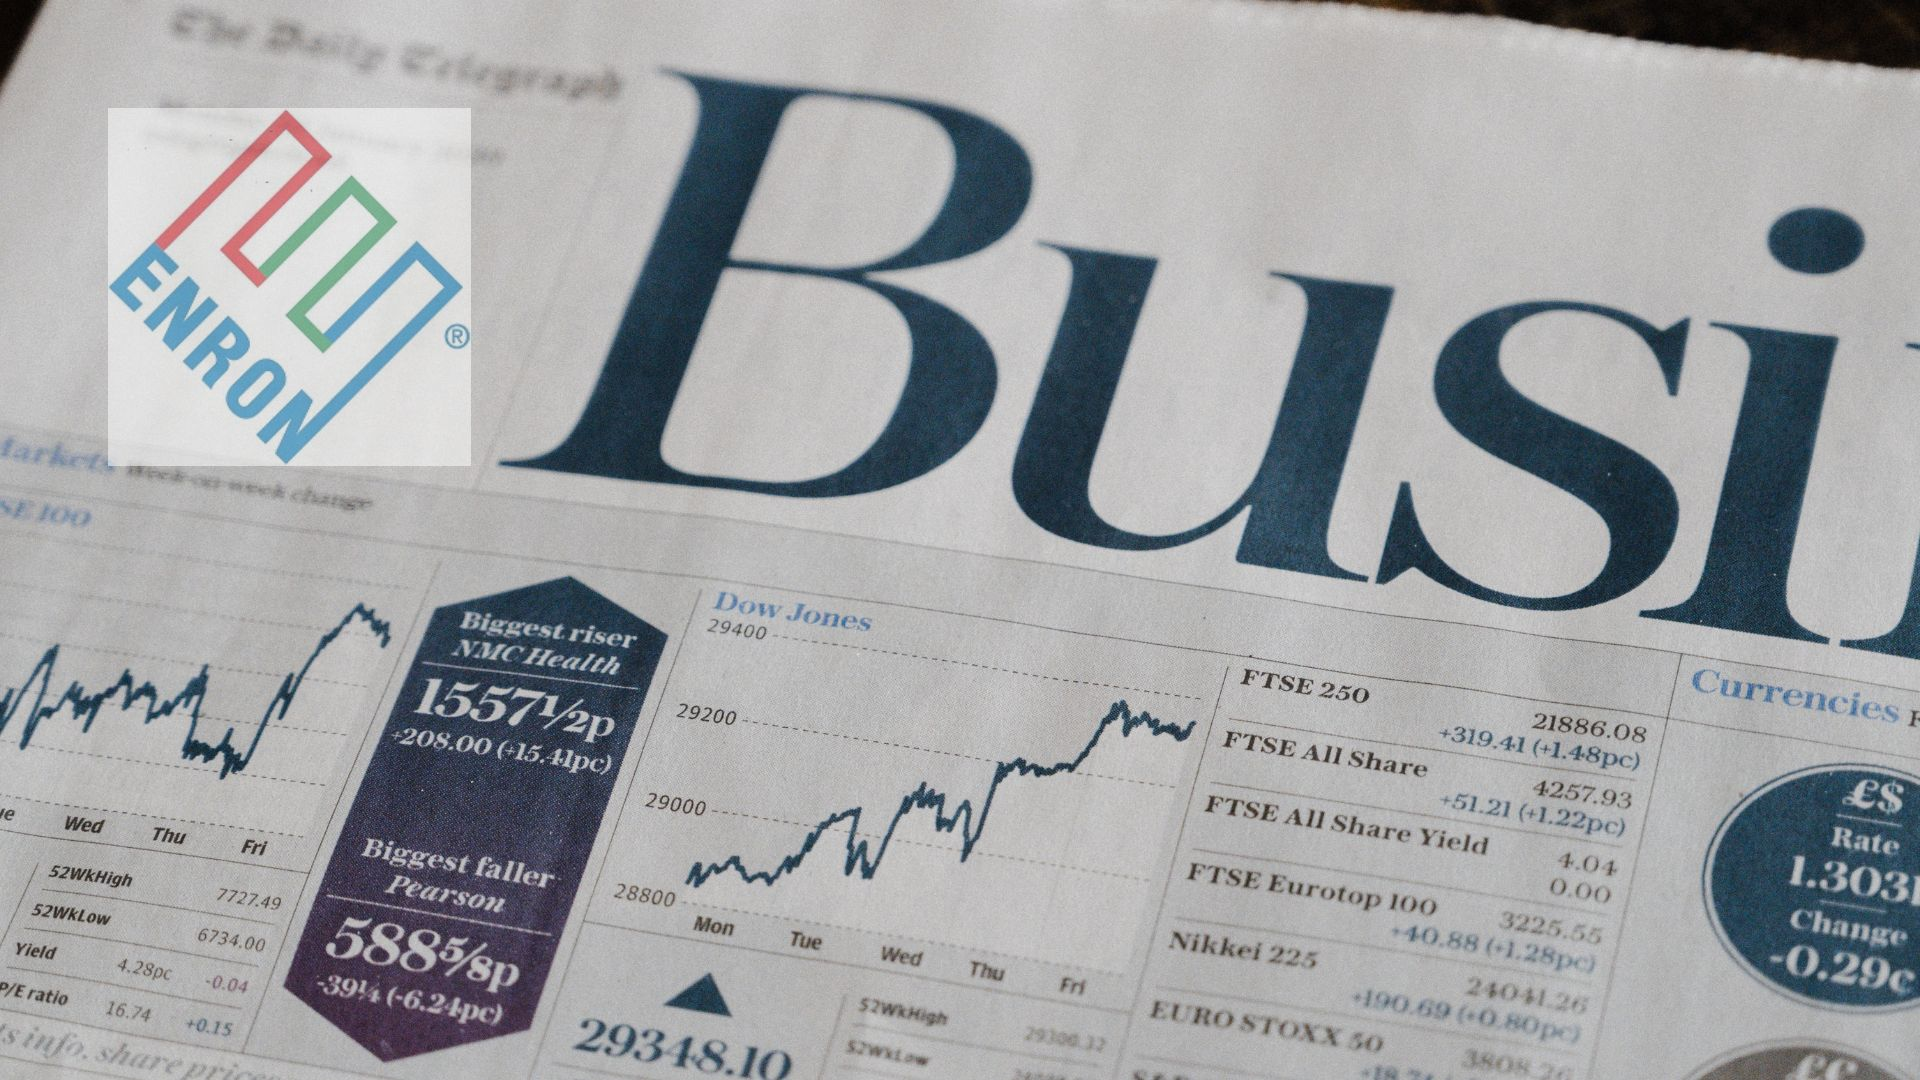

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Welcome" data-toc-modified-id="Welcome-0">Welcome</a></span></li><li><span><a href="#Dataset-description" data-toc-modified-id="Dataset-description-1">Dataset description</a></span></li><li><span><a href="#Important-libraries" data-toc-modified-id="Important-libraries-2">Important libraries</a></span></li><li><span><a href="#Loading-&amp;-understanding-our-data" data-toc-modified-id="Loading-&amp;-understanding-our-data-3">Loading &amp; understanding our data</a></span></li><li><span><a href="#Text-Cleaning" data-toc-modified-id="Text-Cleaning-4">Text Cleaning</a></span></li><li><span><a href="#Fraudulent-flags" data-toc-modified-id="Fraudulent-flags-5">Fraudulent flags</a></span><ul class="toc-item"><li><span><a href="#Manual-approach" data-toc-modified-id="Manual-approach-5.1">Manual approach</a></span><ul class="toc-item"><li><span><a href="#Visual-represetation" data-toc-modified-id="Visual-represetation-5.1.1">Visual represetation</a></span></li></ul></li><li><span><a href="#Latent-Dirichlet-Allocation-(LDA)--The-natural-language-processing-approach" data-toc-modified-id="Latent-Dirichlet-Allocation-(LDA)--The-natural-language-processing-approach-5.2">Latent Dirichlet Allocation (LDA)- The natural language processing approach</a></span><ul class="toc-item"><li><span><a href="#Visual-representation" data-toc-modified-id="Visual-representation-5.2.1">Visual representation</a></span></li></ul></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-6">Conclusions</a></span></li><li><span><a href="#References" data-toc-modified-id="References-7">References</a></span></li></ul></div>

## Welcome

Hi, welcome to this notebook!

This is the second fraud detection project I am working on and this time,<br> I will analyze text data from emails.

The goal of this project is to create a list of fraudulent terms that will<br> help us to detect fraudulent and non-fraudulent behaviors in emails. I will use two different methods:<br> manual and NLP (natural language processing).

Sounds interesting, isn't it?

Let's start!


## Dataset description

For this project I downloaded an edited version of the dataset<br> [The Enron Email Dataset](https://www.kaggle.com/code/oalvay/enron-emails-complete-preprocessing/notebook) from Kaggle.

The Enron scandal was an accounting scam made by the Enron<br> Corporation, an American energy company based in Texas. 

The Enron company was the result of merging two companies: Houston <br> Natural Gas and InterNorth in 1985. Years later, its management team was able to hide a millions of USD dollars debt from<br> failed deals <br>and projects by using bad accounting practices.This resulted in one of the biggest corporate bankruptcy <br>in U.S. history (for more info<br> about the Enron Scandal:[The Enron Scandal](https://en.wikipedia.org/wiki/Enron_scandal#Further_reading)).

This dataset contains approximately 500,000 emails generated by employees <br>of the Enron Corporation. It was obtained by the Federal Energy Regulatory Commission during its investigation<br> of Enron's collapse.



## Important libraries

In [1]:
# !pip3 install html2text


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


In [1]:
# pandas & numpy:
import numpy as np
import pandas as pd

# visualization:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px

# tokenization:
import re
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.porter import PorterStemmer
import string

# gensim:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
# import pyLDAvis.gensim_models
# import pyLDAvis._display

import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys

sys.path.append("..")

from detector.preprocessor import Preprocessor
from detector.data_loader import LoadEnronData, PersonOfInterest
from detector.labeler import EnronLabeler

#read config.ini file
import configparser
config = configparser.ConfigParser()
config.read('../config.ini')

from html2text import html2text


## Loading & understanding our data

In [3]:
# df=pd.read_csv('Data/emails_cleaned.csv')

# # With "pd.set_option('display.max_columns', None)" we see all the columns of the dataset.
# pd.set_option('display.max_columns', None)
# df.head()


In [2]:
loader = LoadEnronData()
old_data=loader()

LoadEnronData: Loading data from path: /Users/zoey/Fraud-Detector/utils/../data/enron/maildir/
LoadEnronData: Load Data Successful
LoadEnronData: Data Successfully loaded into a DataFrame


In [5]:
l = EnronLabeler(data)
data = l()

EnronLabeler: Initialized Successfully!
EnronLabeler: Appended Subject to Body column
EnronLabeler: Preprocessed Body Column
EnronLabeler: POI Present column added
EnronLabeler: Suspicious Folder column added
EnronLabeler: Check Sender Type column added
EnronLabeler: Unique Mails from sender column added
EnronLabeler: Low Comm column added


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   Folder-User                517401 non-null  object
 1   Folder-Name                517401 non-null  object
 2   Message-ID                 517401 non-null  object
 3   Date                       517401 non-null  object
 4   From                       517401 non-null  object
 5   To                         495554 non-null  object
 6   Subject                    517401 non-null  object
 7   Mime-Version               517372 non-null  object
 8   Content-Type               517372 non-null  object
 9   Content-Transfer-Encoding  517372 non-null  object
 10  X-From                     517372 non-null  object
 11  X-To                       517372 non-null  object
 12  X-cc                       517372 non-null  object
 13  X-bcc                      517372 non-null  

In [7]:
# This is how the dataset looks like after the cleaning process. 

df=data[['From','To','Body','Message-ID','Subject','Suspicious-Folders','POI-Present']]
df.rename(columns={'From':'from','To':'to','Body':'content','Message-ID':'message-id','Subject':'subject'},inplace=True)
df

/var/folders/w3/d1c_m0dx0mv20q7033lt172h0000gn/T/ipykernel_32786/1521634816.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'From':'from','To':'to','Body':'content','Message-ID':'message-id','Subject':'subject'},inplace=True)


,from,to,content,message-id,subject,Suspicious-Folders,POI-Present
0,msagel@home.com,jarnold@enron.com,Status John:I'm not really sure what happened ...,<17334447.1075857585446.JavaMail.evans@thyme>,Status,False,False
1,slafontaine@globalp.com,john.arnold@enron.com,re:summer inverses i suck-hope youve made more...,<19171686.1075857585034.JavaMail.evans@thyme>,re:summer inverses,False,False
2,iceoperations@intcx.com,"icehelpdesk@intcx.com, internalmarketing@intcx...","The WTI Bullet swap contracts Hi, Following th...",<29887033.1075857630725.JavaMail.evans@thyme>,The WTI Bullet swap contracts,False,False
3,jeff.youngflesh@enron.com,"anthony.gilmore@enron.com, colleen.koenig@enro...",Invitation: EBS/GSS Meeting w/Bristol Babcock ...,<29084893.1075849630138.JavaMail.evans@thyme>,Invitation: EBS/GSS Meeting w/Bristol Babcock ...,False,False
4,caroline.abramo@enron.com,mike.grigsby@enron.com,Harvard Mgmt Mike- I have their trader coming ...,<30248874.1075857584813.JavaMail.evans@thyme>,Harvard Mgmt,False,False
...,...,...,...,...,...,...,...
517396,jodi.droll@xcelenergy.com,isas@wscc.com,I (PSCO TPCA) agree with Don. I thought we wer...,<18618854.1075840028791.JavaMail.evans@thyme>,RE: Scheduling Time constant,False,False
517397,mark.hackney@aps.com,isas@wscc.com,"FW: Standards AnnouncementOctober 17, 2001 FYI...",<14350892.1075840028690.JavaMail.evans@thyme>,"FW: Standards Announcement - October 17, 2001",False,False
517398,paul.rice@pacificorp.com,isas@wscc.com,Late tags Nothing is easy is it?? At the risk ...,<21704474.1075840029683.JavaMail.evans@thyme>,Late tags,False,False
517399,gjcarter@bpa.gov,"'hara@enron.com, khara@avistaenergy.com, cara....",RE: BCHA Automatic Denial/Approval I think you...,<9367927.1075840029633.JavaMail.evans@thyme>,RE: BCHA Automatic Denial/Approval,False,False


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   from                517401 non-null  object
 1   to                  495554 non-null  object
 2   content             517401 non-null  object
 3   message-id          517401 non-null  object
 4   subject             517401 non-null  object
 5   Suspicious-Folders  517401 non-null  bool  
 6   POI-Present         517401 non-null  bool  
dtypes: bool(2), object(5)
memory usage: 20.7+ MB


All the variables have the correct data type and the presence of some missing data is confirmed 

In [9]:
# Dropping the missing data from the dataset:

df=df.dropna().reset_index(drop=True)
df

,from,to,content,message-id,subject,Suspicious-Folders,POI-Present
0,msagel@home.com,jarnold@enron.com,Status John:I'm not really sure what happened ...,<17334447.1075857585446.JavaMail.evans@thyme>,Status,False,False
1,slafontaine@globalp.com,john.arnold@enron.com,re:summer inverses i suck-hope youve made more...,<19171686.1075857585034.JavaMail.evans@thyme>,re:summer inverses,False,False
2,iceoperations@intcx.com,"icehelpdesk@intcx.com, internalmarketing@intcx...","The WTI Bullet swap contracts Hi, Following th...",<29887033.1075857630725.JavaMail.evans@thyme>,The WTI Bullet swap contracts,False,False
3,jeff.youngflesh@enron.com,"anthony.gilmore@enron.com, colleen.koenig@enro...",Invitation: EBS/GSS Meeting w/Bristol Babcock ...,<29084893.1075849630138.JavaMail.evans@thyme>,Invitation: EBS/GSS Meeting w/Bristol Babcock ...,False,False
4,caroline.abramo@enron.com,mike.grigsby@enron.com,Harvard Mgmt Mike- I have their trader coming ...,<30248874.1075857584813.JavaMail.evans@thyme>,Harvard Mgmt,False,False
...,...,...,...,...,...,...,...
495549,jodi.droll@xcelenergy.com,isas@wscc.com,I (PSCO TPCA) agree with Don. I thought we wer...,<18618854.1075840028791.JavaMail.evans@thyme>,RE: Scheduling Time constant,False,False
495550,mark.hackney@aps.com,isas@wscc.com,"FW: Standards AnnouncementOctober 17, 2001 FYI...",<14350892.1075840028690.JavaMail.evans@thyme>,"FW: Standards Announcement - October 17, 2001",False,False
495551,paul.rice@pacificorp.com,isas@wscc.com,Late tags Nothing is easy is it?? At the risk ...,<21704474.1075840029683.JavaMail.evans@thyme>,Late tags,False,False
495552,gjcarter@bpa.gov,"'hara@enron.com, khara@avistaenergy.com, cara....",RE: BCHA Automatic Denial/Approval I think you...,<9367927.1075840029633.JavaMail.evans@thyme>,RE: BCHA Automatic Denial/Approval,False,False


In [21]:
# There are 2 text variables in the model: subject and content.  
# we want to join all text data in one single column, therefore we will create a new column called "completed_text".

df["completed_text"]=df["content"]

In [11]:
# df['completed_text']=df['completed_text'].str.replace(r'[^\x00-\x7F]+', '', regex=True)
# df['completed_text']=df['completed_text'].apply(lambda x: re.sub('(?:http\:|https\:|www\.)\S+', '', x)) 
# df['completed_text']=df['completed_text'].str.replace(r'\s[^\w\s]+\s', '', regex=True)
# # df['completed_text']=df['completed_text'].str.replace(r'\\n', '', regex=True)


In [3]:
p=Preprocessor()
p('''
'![](http://images.technoscout.com/images/scout/SantaShowcaseTechLogo.\n\ngif)\n\n**Special Toy Edition  \nNovember 2001  \nSponsored by TechnoScout,  \n_Where technology hits home._**\n\n**Ready to do some simple math? It is now approximately 36 days until\nChristmas morning and 20 days until Hanukkah. If you count in weeks, it all\nadds up to point out the fact that the holidays are just around the corner.\nAre you prepared? Do you even know what your kids want? Here at TechnoScout,\nwe promise that your holiday shopping will be completely hassle-free. Not only\ndo we have the toys that will keep your kids enthralled all year long, but we\nensure that you won\'t waste any time looking for a parking spot and scrapping\nit out with other parents in the stores. The coolest toys are here:**\n\n* * *\n\n|  ![](http://images.technoscout.com/images/scout/3DSkateboardHD.gif) | **A\nhalf pipe in your living room?**\n\nVirtual 3D Skateboarding will have your kids performing airborne tricks and\nexecuting backside 180s in your family room.\n\nSkateboard inside your head with the [ Virtual 3D Skateboard\n](http://www.technoscout.com/general/product/product.asp?product=1\n\n572&s\n\nite=80476)!  \n---|---  \n**Not the X-Games...the FX-Games!**\n\nYour kids will rush down a snow-covered course, and brush up on their\nsnowboarding skills without ever leaving the house.\n\nStep into the third dimension! Try the [ Virtual 3D\nSnowboard](http://www.technoscout.com/general/product/product.asp?product=1\n\n573&s\n\nite=80476) today.\n\n|  ![](http://images.technoscout.com/images/scout/3DSnowboardHD.gif)  \n---|---  \n![](http://images.technoscout.com/images/scout/PowerRigHD.gif) | **Ever wanted\nto drive a 18-Wheeler? Now you can**\n\nThe Power Rig puts you behind the wheel of a powerful 18-Wheeler for long\nhauls, or a spin around the house.\n\nYour kitchen is now a highway truck-stop with the [Power\nRig](http://www.technoscout.com/general/product/product.asp?product=1\n\n569&s\n\nite=80476)!  \n---|---  \n**Let your kids pick a fight...with these robots**\n\nThese robots battle each other with the help of a remote control power glove\nthat lets your children control all the cyber ringside action!\n\nCatch a right hook without feeling a thing. [ ROBOX Battling Robots\n](http://www.technoscout.com/general/product/product.asp?product=1\n\n571&s\n\nite=80476) | ![](http://images.technoscout.com/images/scout/ROBOXHD.gif)  \n---|---  \n![](http://images.technoscout.com/images/scout/MegaMissleLauncherHD.g\n\nif) | **High-tech missile launcher sure to be a "hit" this Christmas**\n\nThe Mega Missile Launcher launches missiles with firing sounds and flashing\nlights!\n\nRealistic tank track puts you in the middle of the action: [ Mega Missle\nLauncher](http://www.technoscout.com/general/product/product.asp?product=1\n\n570&s\n\nite=80476)!  \n---|---  \n**Three games, ten racecourses, one great package of fun!**\n\nNew Radical Racer gives boys and girls all the ingredients of a realistic\nracer in a hand-held console.\n\nA game of skill and speed in the palm of your hand: [ Radical\nRacer](http://www.technoscout.com/general/product/product.asp?product=1\n\n567&s\n\nite=80476) |\n![](http://images.technoscout.com/images/scout/RadicalRacerHD.gif)  \n---|---  \n  \n* * *\n\n**Try them all at:** [**Tech noSco\nut.com**](http://www.technoscout.com/general/index.asp?site=80476)\n\n**Or call** **1-800-566-4157** **And mention Promotional Code 80476**\n\n* * *\n\n  \n_Speak with an online product specialist to receive a special discount through\nthis email only by clicking below...\n\n_ [![](http://server.iad.liveperson.net/hc/80693899/?cmd=repstate&site=8\n\n06938\n\n99&category=en;liveperson;4&ver=1)](http://server.iad.liveperson.net/hc/80693899/?cmd=file&file=visi\n\ntorWa\n\nntsToChat&site=80693899&byhref=1&AEPARAMS)  \n---  \n  \nFactory-direct risk-free technology! Because of our special relationship with\nthe manufacturers of the world\'s most innovative products, we can offer you\nthe exclusive TechnoScout Gift Guarantee. We have extended our 30-day risk-\nfree trial for subscribers to our email updates, so you can return the gift\nfor a full refund of the purchase price, excluding shipping and handling,\nuntil January 30, 2002.\n\n_You are receiving this free email because you are subscribed to the Scouting\nReport._\n\n* * *\n\nIf you wish to subscribe to the free TechnoScout Scouting Report, click below\nor send your e-mail to:  \n[ scout_sub@offer.technoscout.com](mailto:scout_sub@offer.technoscout.com)\n\nIf you wish to unsubscribe from the Scouting Report, click below or send your\ne-mail to:  \n[scout_unsub@offer.tech nosco\nut.com](mailto:scout_unsub@offer.technoscout.com).\n\nCopyright 2001, [\nTechnoScout.com](http://www.technoscout.com/general/index.asp?site=80476)  \n![](http://offer.technoscout.com/cgi-bin10/flosensing?y=Mso0CL8Se0GD8R)\n\n
''')

'\'![]( gif) **Special Toy Edition November 2001 Sponsored by TechnoScout, _Where technology hits home._** **Ready to do some simple math? It is now approximately 36 days until Christmas morning and 20 days until Hanukkah. If you count in weeks, it all adds up to point out the fact that the holidays are just around the corner. Are you prepared? Do you even know what your kids want? Here at TechnoScout, we promise that your holiday shopping will be completely hassle-free. Not only do we have the toys that will keep your kids enthralled all year long, but we ensure that you won\'t waste any time looking for a parking spot and scrapping it out with other parents in the stores. The coolest toys are here:***|| **A half pipe in your living room?** Virtual 3D Skateboarding will have your kids performing airborne tricks and executing backside 180s in your family room. Skateboard inside your head with theVirtual 3D Skateboard572&s; ite=80476)!**Not the X-Games...the FX-Games!** Your kids will r

In [35]:
html2text(old_data.loc[old_data['Body'].str.contains('enthralled all year long,'),'Body'].tolist()[0])

'![](http://images.technoscout.com/images/scout/SantaShowcaseTechLogo.\n\ngif)\n\n**Special Toy Edition  \nNovember 2001  \nSponsored by TechnoScout,  \n_Where technology hits home._**\n\n**Ready to do some simple math? It is now approximately 36 days until\nChristmas morning and 20 days until Hanukkah. If you count in weeks, it all\nadds up to point out the fact that the holidays are just around the corner.\nAre you prepared? Do you even know what your kids want? Here at TechnoScout,\nwe promise that your holiday shopping will be completely hassle-free. Not only\ndo we have the toys that will keep your kids enthralled all year long, but we\nensure that you won\'t waste any time looking for a parking spot and scrapping\nit out with other parents in the stores. The coolest toys are here:**\n\n* * *\n\n|  ![](http://images.technoscout.com/images/scout/3DSkateboardHD.gif) | **A\nhalf pipe in your living room?**\n\nVirtual 3D Skateboarding will have your kids performing airborne tricks and

In [22]:
df.loc[df['completed_text'].str.contains('h') & df['Suspicious-Folders']==True,'content'].tolist()[8]

'TechnoSanta picks the Top 5 toys for the holidays ![](<URL> gif) **Special Toy Edition November 2001 Sponsored by TechnoScout, _Where technology hits home._** **Ready to do some simple math? It is now approximately 36 days until Christmas morning and 20 days until Hanukkah. If you count in weeks, it all adds up to point out the fact that the holidays are just around the corner. Are you prepared? Do you even know what your kids want? Here at TechnoScout, we promise that your holiday shopping will be completely hassle-free. Not only do we have the toys that will keep your kids enthralled all year long, but we ensure that you won\'t waste any time looking for a parking spot and scrapping it out with other parents in the stores. The coolest toys are here:** * ![](<URL>**A half pipe in your living room?** Virtual 3D Skateboarding will have your kids performing airborne tricks and executing backside 180s in your family room. Skateboard inside your head with theVirtual 3D Skateboard ](<URL> 

In [13]:
html2text('''
Thomas Friedman\'s Insights into Terrorism <html> <body link="#000066"> <!-- saved from url=(0022)http://internet.e-mail --> <TABLE cellSpacing=0 cellPadding=0 width=600 bgColor=#ffffff border=0> <TBODY> <TR> <TD vAlign=top width=600><!-- Flag goes here --><A href="http://www.nytimes.com?rd=hcmcp?p=042BuK042Buk42D3L012000mwoSOwo3p"><IMG height=40 hspace=0 src="http://graphics.nytimes.com/images/email/edit/newflag.gif" width=600 align=left border=0></A> </TD></TR> <TR> <TD vAlign=top width=600><!-- Search box begins --> <TABLE cellSpacing=0 cellPadding=0 width=600 border=0> <FORM action=http://archives.nytimes.com/plweb-cgi/search.cgi method=post><INPUT type=hidden value=ALL name=fields> <INPUT type=hidden value=ALL name=section> <TBODY> <TR> <TD bgColor=#000000 height=2><IMG height=1 hspace=0 src="http://graphics.nytimes.com/images/misc/spacer.gif" width=1 align=left border=0></TD></TR> <TR> <TD bgColor=#cccccc height=25>&nbsp; <FONT face="verdana, arial, helvetica, sans-serif" size=-1>Search NYTimes.com <INPUT maxLength=32 name=thequery> <SELECT name=thedbs> <OPTION value=Today>Today\'s News<OPTION value=site2weeks>Past 2 Weeks<OPTION value=past30days selected>Past 30 Days<OPTION value=past90days>Past 90 Days<OPTION value=past365days>Past Year<OPTION value=Full>Since 1996</OPTION></SELECT> <INPUT type=image height=19 alt=submit width=18 src="http://graphics.nytimes.com/images/global/global_search/gs_submit.gif" align=top value=" Search " border=0 name=submit> </FONT></TD></TR></FORM></TBODY></TABLE><!-- Search box ends --></TD></TR> <TR> <TD vAlign=top width=600> <table width="132" align="right" border="0" cellpadding="5"> <tr> <td> <A href="http://www.nytimes.com/unsubscribe?rd=hcmcp?p=042BuF042Buk42D3L012000mwoSOwo3p"> <IMG alt="E-mail Preferences" hspace=0 src="http://www.nytimes.com/images/email/edit/unsubscribe.gif" width=122 align=left border=0></A> <br clear="all"> <A href="http://www.nytimes.com/email?rd=hcmcp?p=042BuD042Buk42D3L012000mwoSOwo3p"><IMG alt="Customize This E-Mail" hspace=0 src="http://www.nytimes.com/images/email/edit/nytnewsletters.gif" width=122 align=left border=0></A> <br clear="all"> <A href="http://www.nytimes.com/email?rd=hcmcp?p=042BuC042Buk42D3L012000mwoSOwo3p"><IMG alt="Customize This E-Mail" hspace=0 src="http://www.nytimes.com/images/email/edit/textversion.gif" width=122 align=left border=0></A> </td> </tr> </table> <!-- Content begins --> <br><b>February 7, 2002</B> </P> <P>Dear NYTimes.com Member, <P> After the events of Sept. 11, it\'s more important than ever to stay informed about terrorist activities occurring around the globe. To help, we\'ve created two special online Topics of the Times offerings that we\'d like to share with you. Each contains a series of up to nine archived Op-Ed columns by Thomas Friedman, National Book Award winner and foreign affairs columnist for The New York Times. <P> Priced at only $4.95 each, these riveting collections put at your fingertips the insightful, Pulitzer Prize-winning perspectives of America\'s foremost commentator on the Middle East, terrorism and globalization. <P> "Thomas Friedman on Terrorism" contains six pre-Sept. 11 columns about the threat of terrorism and the conflict in the Middle East: <br><br> -- Digital Defense<br> -- A Memo From Osama <br> -- Angry, Wired and Deadly <br> -- Motives for the Bombing <br> -- The Terrorist Question<br> -- Beirut, Oklahoma <br><br> <strong><a href="http://www.nytimes.com/timestopics/friedman.html?rd=hcmcp?p=042Bu9042Buk42D3L012000mwoSOwo3p">Click here</a></strong> to view this collection. <P> "Thomas Friedman on Sept 11" has these nine Op-Ed columns published in the first 30 days after the attacks: <br><br> -- World War III <br> -- The Big Terrible <br> -- Hama Rules <br> -- Terrorism Game Theory <br> -- Talk Later (Sept. 28, 2001) <br> -- Eastern Middle School <br> -- Yes, but What <br> -- It\'s Freedom, Stupid <br> -- Bush to bin Laden <br><br> <a href="http://www.nytimes.com/timestopics/september.html?rd=hcmcp?p=042Bu3042Buk42D3L012000mwoSOwo3p"><strong>Click here</strong></a> to view this collection. <P> You might also want to order these other <strong><a href="http://www.nytimes.com/timestopics?rd=hcmcp?p=042Bt$042Buk42D3L012000mwoSOwo3p">Topics of The Times</a></strong> offerings: <br> <BR> <font size="-1"> &nbsp;&#149;&nbsp;<a href="http://www.nytimes.com/timestopics/naipaul.html?rd=hcmcp?p=042Buj042Buk42D3L012000mwoSOwo3p"><strong>Authors in Depth: V.S. Naipaul</strong></a><br> &nbsp;&#149;&nbsp;<a href="http://www.nytimes.com/timestopics/desserts.html?rd=hcmcp?p=042Buf042Buk42D3L012000mwoSOwo3p"><strong>Winter Desserts</strong></a><br> &nbsp;&#149;&nbsp;<a href="http://www.nytimes.com/timestopics/safire.html?rd=hcmcp?p=042Bua042Buk42D3L012000mwoSOwo3p"><strong>William Safire: On Language</strong></a><br> &nbsp;&#149;&nbsp;<a href="http://www.nytimes.com/timestopics/hawaii.html?rd=hcmcp?p=042BuY042Buk42D3L012000mwoSOwo3p"><strong>Destination Hawaii</strong></a> </font> <P> Each collection is just $4.95 and contains up to nine archived articles. <P> Thank you for being a valued subscriber and for your continued interest in NYTimes.com. <P> Sincerely, <P> The New York Times on the Web <P> P.S. If you have a friend or colleague who might be interested, feel free to forward this e-mail. <BR clear=all> <HR SIZE=1 width="600"> <FONT face="verdana, arial, helvetica, sans-serif" size=1><B>About This E-Mail</B><BR>Your registration to NYTimes.com included permission to send you information about new features and services. As a member of the BBBOnline Privacy Program and the TRUSTe privacy program, we are committed to protecting your privacy. Suggestions and feedback are welcome at <A href="mailto:feedback@nytimes.com">feedback@nytimes.com</A>. <P><B>How to Unsubscribe</B><BR>To unsubscribe from future mailings, visit <A href="http://www.nytimes.com/unsubscribe/?rd=hcmcp?p=042BuW042Buk42D3L012000mwoSOwo3p">http://www.nytimes.com/unsubscribe</A>. <P><B>How to Advertise</B><BR>For information on advertising in e-mail newsletters with The New York Times on the Web, please contact <A href="mailto:onlinesales@nytimes.com">onlinesales@nytimes.com</A> or visit our <A href="http://www.nytimes.com/adinfo/?rd=hcmcp?p=042BuP042Buk42D3L012000mwoSOwo3p">online media kit</A>. <P><!--<IMG SRC="poweredby.gif" WIDTH="120" HEIGHT="31" HSPACE="0" VSPACE="0" BORDER="0" ALIGN="right">--></FONT> <P><FONT face="Times New Roman, Times" size=-1><B><A href="http://www.nytimes.com/info/help/copyright.html">Copyright 2002 The New York Times Company</A></B></FONT> <BR><br> <FONT size=1><B>Powered By:</B><A href="http://www.annuncio.com"><IMG height="52" src="http://graphics.nytimes.com/images/email/circuits/annuncio.gif" width="91" border="0"></A> <IMG src="http://images2.nytimes.com/RealMedia/ads/adstream_nx.cgi/email.nytimes.com/editpromo/html@Bottom1" width="0" height="0"> <!-- Content ends --><BR></TD></TR></P></FONT></FONT></TABLE>
''')

'Thomas Friedman\'s Insights into Terrorism\n[![](http://graphics.nytimes.com/images/email/edit/newflag.gif)](http://www.nytimes.com?rd=hcmcp?p=042BuK042Buk42D3L012000mwoSOwo3p)  \n---  \n| ![](http://graphics.nytimes.com/images/misc/spacer.gif)  \n---  \n  Search NYTimes.com  Today\'s NewsPast 2 WeeksPast 30 DaysPast 90 DaysPast\nYearSince 1996  \n|  [ ![E-mail\nPreferences](http://www.nytimes.com/images/email/edit/unsubscribe.gif)](http://www.nytimes.com/unsubscribe?rd=hcmcp?p=042BuF042Buk42D3L012000mwoSOwo3p)  \n[![Customize This\nE-Mail](http://www.nytimes.com/images/email/edit/nytnewsletters.gif)](http://www.nytimes.com/email?rd=hcmcp?p=042BuD042Buk42D3L012000mwoSOwo3p)  \n[![Customize This\nE-Mail](http://www.nytimes.com/images/email/edit/textversion.gif)](http://www.nytimes.com/email?rd=hcmcp?p=042BuC042Buk42D3L012000mwoSOwo3p)  \n---  \n  \n**February 7, 2002**\n\nDear NYTimes.com Member,\n\nAfter the events of Sept. 11, it\'s more important than ever to stay informed\nabout te

## Text Cleaning

As in the numerical databases, cleaning data is a crucial part of the text analysis, and the process has 4 steps:
    <ol>
  <li>Remove all Stopwords</li>
  <li>Lemanize your words</li>
  <li>Stem your words</li>
  <li>Tokenization</li>
</ol>

In [14]:
# Getting stopwords for English:

stop_words = set(stopwords.words('english')) 


In [15]:
# Adding additional stop words from nltk. Since we are working with emails we will include words like: from, to,...

stop_words.update(('from','to','cc','http', 're', 'www', 'com','subject','sent','email','u','ok','thanks','please','ect'))

In [16]:
# Define punctuations to exclude and lemmatizer:

exclude = set(string.punctuation)

In [17]:
# Creating text data cleaning function:

def clean(text,stop_words):
    stop_words = set(stopwords.words('english'))
    stop_words.update(('from','to','cc','http', 're', 'www', 'com','subject','sent','email','u','ok','thanks','please','ect','dt','pm'))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    porter= PorterStemmer()
    
    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop_words) and (not i.isdigit()) and len(i)>3)])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    #stem = " ".join(porter.stem(token) for token in normalized.split())
    
    return normalized

In [18]:
# Since the dataset is too big to work with, we will choose ramdomly a sample of 1200 rows. 

sample_df=df[df['Suspicious-Folders']==True]
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46485 entries, 92 to 494267
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   from                46485 non-null  object
 1   to                  46485 non-null  object
 2   content             46485 non-null  object
 3   message-id          46485 non-null  object
 4   subject             46485 non-null  object
 5   Suspicious-Folders  46485 non-null  bool  
 6   POI-Present         46485 non-null  bool  
 7   completed_text      46485 non-null  object
dtypes: bool(2), object(6)
memory usage: 2.6+ MB


In [19]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/zoey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
# Clean the emails in sample_df

text_clean=[]
for text in sample_df['completed_text']:
    text_clean.append(clean(text, stop_words).split())    


KeyboardInterrupt: 

In [ ]:
# Apply the function to the dataframe:

sample_df['clean_text'] = text_clean

/var/folders/w3/d1c_m0dx0mv20q7033lt172h0000gn/T/ipykernel_30559/494257741.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['clean_text'] = text_clean


In [ ]:
# Now we can compare the original column "completed_text" vs the column "clean_text" using the row 41100 from sample_df
# Completed_text:

sample_df['completed_text'][96]

"fw: move related issues please make sure you are completely packed by 3:00 pm. the move team will be on the floor by 3:00 pm. also: 1. empty voicemail 2. take home laptops and palm pilots, ipaq's or blackberry's 3. to be here at least one hour prior to your normal time on monday morning. the floor will be open by 5:00 am 4. pack headsets. (box, black wire to earpiece and black cord that connects under desk) only leave gray wires let me know if there is any questions or if you need any help ina rangel administrative coordinator enron north america 713-853-7257 voice 713-646-3604 fax "

In [ ]:
# clean_text:

print(sample_df['clean_text'][96])

['move', 'related', 'issue', 'make', 'sure', 'completely', 'packed', 'move', 'team', 'floor', 'also', 'empty', 'voicemail', 'take', 'home', 'laptop', 'palm', 'pilot', 'ipaq', 'blackberry', 'least', 'hour', 'prior', 'normal', 'time', 'monday', 'morning', 'floor', 'open', 'pack', 'headset', 'black', 'wire', 'earpiece', 'black', 'cord', 'connects', 'desk', 'leave', 'gray', 'wire', 'know', 'question', 'need', 'help', 'rangel', 'administrative', 'coordinator', 'enron', 'north', 'america', 'voice']


In [ ]:
# Creating a new column named clean_joined where we join the words into a string.

sample_df['clean_joined'] = sample_df['clean_text'].apply(lambda x: " ".join(x))

/var/folders/w3/d1c_m0dx0mv20q7033lt172h0000gn/T/ipykernel_30559/2808233657.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['clean_joined'] = sample_df['clean_text'].apply(lambda x: " ".join(x))


In [ ]:
# Let's see how the text looks like after the cleaning process.

sample_df['clean_joined'][96]

'move related issue make sure completely packed move team floor also empty voicemail take home laptop palm pilot ipaq blackberry least hour prior normal time monday morning floor open pack headset black wire earpiece black cord connects desk leave gray wire know question need help rangel administrative coordinator enron north america voice'

## Fraudulent flags

Now that the dataset is clean, I can get the fraudulent terms that will help me to create the fraudulent flags.


### Manual approach

In [ ]:
# In order to use the manual approach knowledge field is key as the analysts needs to know wery well what they are looking for in the emails. 
# For example, we know that Enron employees activaley participated in the fraud by keeping the stock price manually high. 
# We can create a list of fraudulent terms that helps us to find the emails with reference to the word "stock".

fraud_list=['stock','enron stock','sell stock','bonus','wall street','the market','down jones','board','bourse','investment','weak finantials','accounting','enron stock price']

# Now we filter the column "completed text" using the list "fraud_list".


filtered_emails = sample_df.loc[sample_df['clean_joined'].str.contains('|'.join(fraud_list), na=False)]


In [ ]:
# "filtered_emails" represents the emails with fraudulent terminology. 
# We will create a new column named fraud in the dataframe. 
# The new column will have 2 values: 0: non-fraud ; 1: fraud

sample_df['fraud'] = np.where((sample_df['clean_joined'].str.contains('|'.join(fraud_list)) == True), 1, 0)
        
sample_df.head()    

/var/folders/w3/d1c_m0dx0mv20q7033lt172h0000gn/T/ipykernel_30559/1143287955.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['fraud'] = np.where((sample_df['clean_joined'].str.contains('|'.join(fraud_list)) == True), 1, 0)


,from,to,content,message-id,subject,Suspicious-Folders,POI-Present,completed_text,clean_text,clean_joined,fraud
92,soblander@carrfut.com,soblander@carrfut.com,option candlesticks as a hot link 10/5 The inf...,<25351532.1075852689302.JavaMail.evans@thyme>,option candlesticks as a hot link 10/5,True,False,option candlesticks as a hot link 10/5 the inf...,"[option, candlestick, link, information, conta...",option candlestick link information contained ...,0
93,errol.mclaughlin@enron.com,"john.arnold@enron.com, bilal.bajwa@enron.com, ...",TRV Notification: (NG - PROPT P/L - 11/20/2001...,<22134312.1075861665211.JavaMail.evans@thyme>,TRV Notification: (NG - PROPT P/L - 11/20/2001),True,False,trv notification: (ngpropt p/l11/20/2001) the ...,"[notification, ngpropt, report, named, ngpropt...",notification ngpropt report named ngpropt lpub...,0
94,carrfuturesenergy@carrfut.com,rvujtech@carrfut.com,revised unleaded chart 11/27 Unleaded http://w...,<17391691.1075861672096.JavaMail.evans@thyme>,revised unleaded chart 11/27,True,False,revised unleaded chart 11/27 unleaded,"[revised, unleaded, chart, unleaded]",revised unleaded chart unleaded,0
95,dailyquote@smtp.quote.com,jarnold@enron.com,[IMAGE]=09Quote.com =09 Log In | Sign Up | Ac...,<27157097.1075852698801.JavaMail.evans@thyme>,The Daily Quote,True,False,[image]=09quote.com =09 log insign upaccount ...,"[image, quote, insign, upaccount, insight, cen...",image quote insign upaccount insight center im...,1
96,ina.rangel@enron.com,"dutch.quigley@enron.com, john.arnold@enron.com...",FW: Move Related Issues PLEASE MAKE SURE YOU A...,<21604342.1075861668678.JavaMail.evans@thyme>,FW: Move Related Issues,True,False,fw: move related issues please make sure you a...,"[move, related, issue, make, sure, completely,...",move related issue make sure completely packed...,0


In [ ]:

count = sample_df['fraud'].value_counts()
print(count)


0    40160
1     6325
Name: fraud, dtype: int64


We have got our first results! We have been able to detect 86 out of 1200 emails with fraudulent terminology. 

#### Visual represetation

Visual represetation can be a very powerful tool in text analysis. 

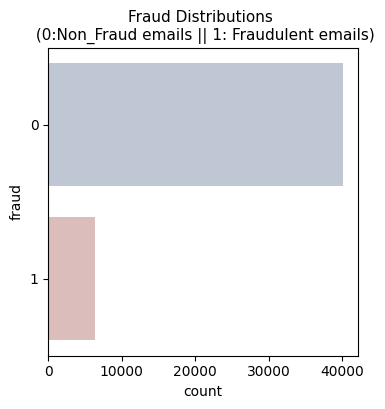

In [ ]:
# Count plot to see fraudulent and non-fraudulent emails

plt.figure(figsize = (4, 4))
sns.countplot(y = "fraud", data = sample_df,palette='vlag')
plt.title('Fraud Distributions \n (0:Non_Fraud emails || 1: Fraudulent emails)', fontsize=11)
plt.show()

Another interesting visualization for text analysis is WordCloud. <br>
This library visualizes data in the form of text where the font<br> size represents the frequency / importance of the word in the text.

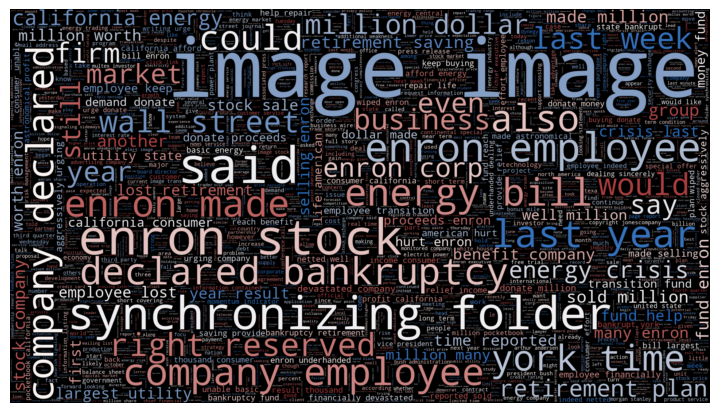

In [ ]:
# plot the word cloud for text that is considered "fraud"

plt.figure(figsize = (7,7)) 
wc = WordCloud(max_words = 2000 , width = 1920 , height = 1080 ,colormap='vlag', stopwords = stop_words).generate(" ".join(sample_df[sample_df.fraud == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Wordclood result is very intersting. Words like enron, company, market, image, <br>business are very frequent in the emails classified as fraud. 

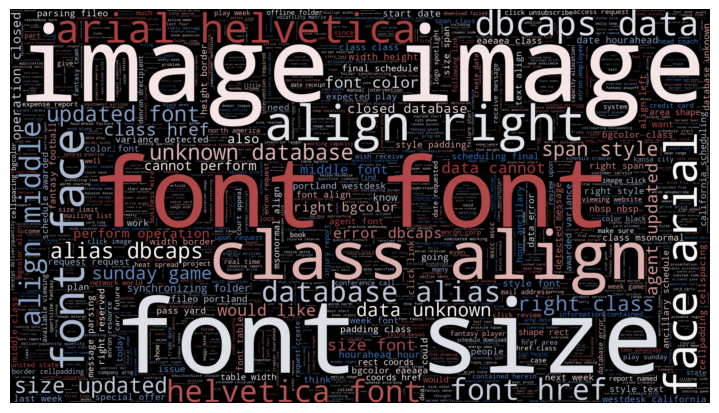

In [ ]:
# plot the word cloud for text that is considered "non-fraud"
plt.figure(figsize = (7,7)) 
wc = WordCloud(max_words = 2000 , width = 1920 , height = 1080 ,colormap='vlag', stopwords = stop_words).generate(" ".join(sample_df[sample_df.fraud == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Latent Dirichlet Allocation (LDA)- The natural language processing approach

"LDA is a generative statistical model that explains a set of <br>observations through unobserved groups, and each group explains why some parts of the data are similar. <br>The LDA is an example of a <br>opic model. There, observations (e.g., words) are collected into documents, and each word's presence <br>is attributable to one of the<br> document's topics. Each document will contain a small number of topics".<br>([LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)). 

In order to apply LDA we need to follow these steps:

 <ol>
  <li>Clean the text data</li>
  <li>Create a bag of words with dictionary and corpus</li>
  <li>Fed dictionary and corpus into the LDA model</li>
  
</ol>




In [ ]:
# Define the dictionary. 
# The dictionary contains the number of times a word appears for each word. 

dictionary = corpora.Dictionary(text_clean)


In [ ]:
# Filter non frequent words

# This formula filters the words that appear in less than 10 emails and keep the 50000 most frequent words.

dictionary.filter_extremes(no_below=10, keep_n=50000)

In [ ]:
# Define the corpus 
corpus = [dictionary.doc2bow(text) for text in text_clean]


In [ ]:
# Define the LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=20, id2word=dictionary, passes=15,random_state=42)

# Save the topics and top 5 words
topics = ldamodel.print_topics(num_words=5)

# Print the results
for topic in topics:
    print(topic)

(0, '0.110*"enron" + 0.047*"company" + 0.046*"employee" + 0.036*"million" + 0.027*"stock"')
(1, '0.023*"fare" + 0.022*"travel" + 0.020*"maggi" + 0.016*"deal" + 0.014*"hotel"')
(2, '0.017*"would" + 0.016*"mike" + 0.016*"know" + 0.013*"like" + 0.011*"going"')
(3, '0.022*"mail" + 0.022*"click" + 0.018*"free" + 0.018*"offer" + 0.012*"receive"')
(4, '0.253*"folder" + 0.047*"item" + 0.025*"mailbox" + 0.024*"court" + 0.021*"offline"')
(5, '0.026*"company" + 0.021*"business" + 0.020*"information" + 0.019*"service" + 0.014*"technology"')
(6, '0.198*"font" + 0.080*"class" + 0.070*"size" + 0.065*"align" + 0.051*"href"')
(7, '0.023*"enron" + 0.019*"michelle" + 0.018*"nelson" + 0.012*"report" + 0.011*"indeed"')
(8, '0.032*"meeting" + 0.023*"call" + 0.016*"time" + 0.015*"november" + 0.015*"friday"')
(9, '0.064*"data" + 0.063*"database" + 0.061*"message" + 0.039*"unknown" + 0.039*"alias"')
(10, '0.078*"synchronizing" + 0.031*"schedule" + 0.030*"date" + 0.020*"intercontinentalexchange" + 0.018*"final"

In [ ]:
topics = ldamodel.print_topics(num_words=17)
for topic in topics:
    print(topic)

(0, '0.026*"enron" + 0.017*"company" + 0.014*"energy" + 0.011*"million" + 0.011*"employee" + 0.011*"stock" + 0.008*"fund" + 0.007*"made" + 0.007*"market" + 0.007*"california" + 0.007*"year" + 0.007*"consumer" + 0.006*"donate" + 0.006*"said" + 0.005*"state" + 0.005*"bill" + 0.005*"bankruptcy"')
(1, '0.010*"travel" + 0.009*"fare" + 0.008*"hotel" + 0.007*"night" + 0.007*"city" + 0.007*"special" + 0.006*"offer" + 0.006*"deal" + 0.006*"great" + 0.006*"time" + 0.005*"sale" + 0.005*"visit" + 0.005*"point" + 0.005*"rate" + 0.005*"vacation" + 0.005*"ticket" + 0.004*"save"')
(2, '0.019*"enron" + 0.008*"schedule" + 0.007*"mike" + 0.007*"know" + 0.007*"mail" + 0.007*"meeting" + 0.007*"date" + 0.007*"call" + 0.006*"maggi" + 0.006*"question" + 0.005*"message" + 0.005*"need" + 0.005*"employee" + 0.005*"hour" + 0.005*"would" + 0.005*"time" + 0.004*"final"')
(3, '0.043*"font" + 0.024*"updated" + 0.020*"week" + 0.020*"game" + 0.018*"class" + 0.015*"size" + 0.014*"align" + 0.014*"fantasy" + 0.012*"right"

In [ ]:
document_topics = ldamodel.get_document_topics(corpus, minimum_probability=0.0)


In [ ]:
dominant_topic = [max(topic, key=lambda x: x[1]) for topic in document_topics]


In [ ]:
document_to_topic = {}  # Create a mapping of documents to topics

for i, doc in enumerate(text_clean):
    doc_id = i  # You can use a unique identifier here
    doc_topic = dominant_topic[i][0]  # The dominant topic for this document
    document_to_topic[doc_id] = doc_topic

# Now you can access the dominant topic for any document
print(document_to_topic[0])  # The dominant topic for the first document


1


In [ ]:
d=[]
for i in range(0,len(text_clean)):
    if(document_to_topic[i]==0):
        d.append(' '.join(text_clean[i]))


In [ ]:
d[0]

'protect privacy html head title internet eraser title meta equiv content type content text html charset meta name generator content adobe pagemill base target blank head body bgcolor ffffff topmargin leftmargin marginwidth marginheight nakedwomansex eraser john arnold enron width height center table width border cellspacing cellpadding bgcolor ffccff center font color size face tahoma surfing porn font center bgcolor ccff center font color size face tahoma wife know porn habit font center table table width border cellspacing cellpadding bgcolor ffffcc center font color size face tahoma tell anyone computer tell font center table width href nakedwomansex eraser index john arnold enron font size face arial helvetica sans serif font color protect internet eraser font font width table width border cellspacing cellpadding height align center width height valign colspan table width border cellspacing cellpadding height width height width height width height width bgcolor width height center

In [ ]:
dominant_topic

[(1, 0.94663346),
 (3, 0.96954244),
 (1, 0.91535556),
 (1, 0.5052665),
 (2, 0.5081739),
 (2, 0.6239933),
 (2, 0.92492086),
 (2, 0.8471497),
 (1, 0.38224036),
 (2, 0.7273317),
 (1, 0.61341935),
 (3, 0.60135627),
 (1, 0.45482698),
 (1, 0.99487203),
 (3, 0.9694075),
 (3, 0.96940744),
 (2, 0.69004333),
 (1, 0.571967),
 (3, 0.96940935),
 (3, 0.6619014),
 (1, 0.95581555),
 (2, 0.9503427),
 (2, 0.8305828),
 (1, 0.985731),
 (2, 0.7778996),
 (1, 0.87073153),
 (2, 0.89931583),
 (1, 0.9938832),
 (2, 0.63658583),
 (1, 0.97182256),
 (2, 0.9235479),
 (3, 0.96954125),
 (3, 0.53662556),
 (2, 0.87303656),
 (1, 0.35908327),
 (0, 0.8158229),
 (3, 0.7121998),
 (3, 0.5265725),
 (1, 0.84758157),
 (2, 0.5604488),
 (3, 0.96954167),
 (1, 0.64537),
 (2, 0.9304238),
 (2, 0.8096568),
 (2, 0.6910406),
 (1, 0.5660718),
 (1, 0.8510779),
 (2, 0.57034445),
 (1, 0.44870403),
 (3, 0.967683),
 (1, 0.9968941),
 (3, 0.96941227),
 (1, 0.9946726),
 (2, 0.5331585),
 (1, 0.74302655),
 (2, 0.8134763),
 (2, 0.801644),
 (3, 0.512

#### Visual representation

In order to fully understand the topics of our model we need to visualize.<br> Lda_display is a great library from gensim that we can use for this purpose.


In [ ]:
!pip3 install pyLDAvis

ERROR: Could not find a version that satisfies the requirement pyLDAvis.display (from versions: none)
ERROR: No matching distribution found for pyLDAvis.display

[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


In [ ]:

lda_display = pyLDAvis.gensim_models.prepare(ldamodel,corpus,dictionary,sort_topics=False)

pyLDAvis.display(lda_display)


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
# Note: It is necessary to run the notebook in your computer in order to see the visualization
# as an alternative solution, we can save it as a html file and insert a screenshot of the visualization. 

# save the visualization:
pyLDAvis.save_html(lda_display, 'lda.html')


Each bubble represents a different topic. <br>The biggest the bubble the most important/ relevant the topic is in the dataset. 
After analyzing the clusters, <br>we can see that cluster number 2 has terms related to stocks

In [ ]:
# Now we have to assign the topics to the original data:

def get_topic(ldamodel, corpus):
    topic_details_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):  
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic              
                wp = ldamodel.show_topic(topic_num)                
                topic_details_df = topic_details_df.append(pd.Series([topic_num, prop_topic]),ignore_index=True)  
        
    topic_details_df.columns = ['Dominant_Topic', '% Score']
    return topic_details_df


In [ ]:
# Add original text to topic details in a dataframe

contents = pd.DataFrame({'Original text': text_clean})
topic_df = pd.concat([get_topic(ldamodel, corpus), contents], axis=1)


In [ ]:
# Create flag for text highest associated with topic 2

topic_df['fraud_lda_model'] = np.where((topic_df['Dominant_Topic'] == 2.0), 1, 0)


In [ ]:
count = topic_df['fraud_lda_model'].value_counts()
print(count)

0    1138
1      62
Name: fraud_lda_model, dtype: int64


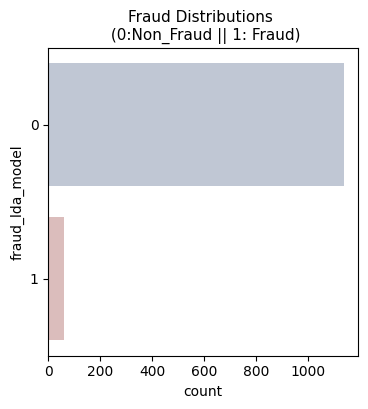

In [ ]:
#Plot the count plot for fraudulent and no fraudulent emails
plt.figure(figsize = (4, 4))
sns.countplot(y = "fraud_lda_model", data = topic_df,palette='vlag')
plt.title('Fraud Distributions \n (0:Non_Fraud || 1: Fraud)', fontsize=11)
plt.show()

## Conclusions

The manual approach applied to the model was not very efficient,<br> as it only classified 86 emails as fraudulent. <br>However LDA improved the model's ability to classify emails allowing us to mark 259 emails.


If you have made it this far, thank you! Feel free to drop me a <br>message with your feedback. Also, I would appreciate if you support me with your vote.



## References

- [Course:Fraud Detection in Python by DataCamp](https://app.datacamp.com/learn/courses/fraud-detection-in-python).
- [The Enron Scandal](https://en.wikipedia.org/wiki/Enron_scandal).
- [LDA](https://es.wikipedia.org/wiki/Latent_Dirichlet_Allocation).
